In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Load the dataset
data = pd.read_csv("depression_data.csv")

# Handle missing values or drop unnecessary columns if needed
data.drop(columns=["Name"], inplace=True, errors='ignore')

# Encoding categorical variables
data_encoded = pd.get_dummies(data, drop_first=True)

# Separate features and target
X = data_encoded.drop('Chronic Medical Conditions_Yes', axis=1)
y = data_encoded['Chronic Medical Conditions_Yes']

# Split into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

# Balance the training data using SMOTE
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Scale the data
scaler = StandardScaler()
X_train_balanced_scaled = scaler.fit_transform(X_train_balanced)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)


Voting Classifier Metrics: {'Accuracy': 0.6009667284298719, 'Precision': 0.33250907966926824, 'Recall': 0.21061132592628848, 'F1 Score': 0.2578808582044828}
Confusion Matrix:
 [[32996  8638]
 [16128  4303]]
Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.79      0.73     41634
        True       0.33      0.21      0.26     20431

    accuracy                           0.60     62065
   macro avg       0.50      0.50      0.49     62065
weighted avg       0.56      0.60      0.57     62065



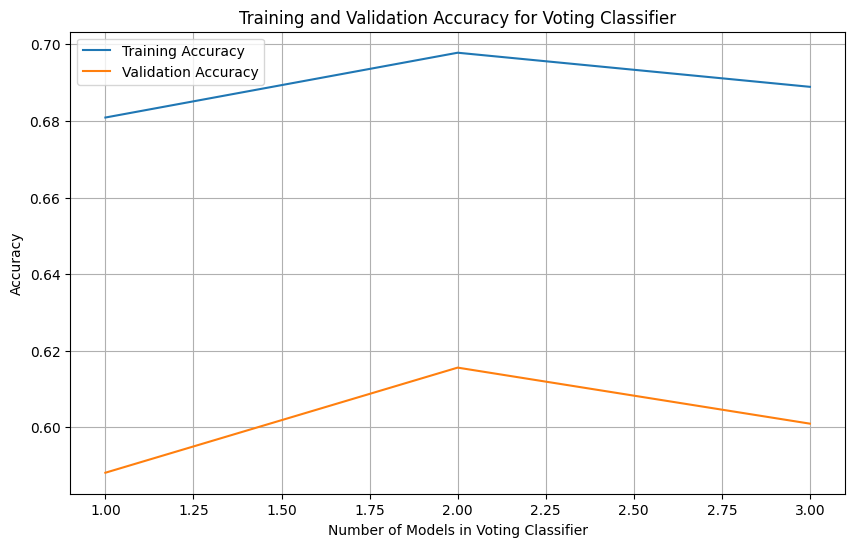

In [2]:
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Initialize individual models
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)
dt_clf = DecisionTreeClassifier(max_depth=5, random_state=42)
gnb = GaussianNB()

# Create Voting Classifier
voting_clf = VotingClassifier(
    estimators=[
        ('Logistic Regression', log_reg),
        ('Decision Tree', dt_clf),
        ('Naive Bayes', gnb)
    ],
    voting='soft'  # Use soft voting for better probability-weighted performance
)

# Initialize storage for metrics
train_accuracies = []
val_accuracies = []

# Simulate training loop to collect metrics
for i in range(1, len(voting_clf.estimators) + 1):
    # Create a VotingClassifier with the first `i` models
    partial_voting_clf = VotingClassifier(
        estimators=voting_clf.estimators[:i],
        voting='soft'
    )

    # Train the partial Voting Classifier
    partial_voting_clf.fit(X_train_balanced_scaled, y_train_balanced)

    # Predict on training and validation data
    y_train_pred = partial_voting_clf.predict(X_train_balanced_scaled)
    y_val_pred = partial_voting_clf.predict(X_val_scaled)

    # Calculate accuracies
    train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))
    val_accuracies.append(accuracy_score(y_val, y_val_pred))

# Train the final Voting Classifier
voting_clf.fit(X_train_balanced_scaled, y_train_balanced)

# Predict on validation data
y_val_pred_voting = voting_clf.predict(X_val_scaled)

# Evaluate the final model
voting_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_voting),
    "Precision": precision_score(y_val, y_val_pred_voting),
    "Recall": recall_score(y_val, y_val_pred_voting),
    "F1 Score": f1_score(y_val, y_val_pred_voting)
}
print("Voting Classifier Metrics:", voting_metrics)
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_voting))
print("Classification Report:\n", classification_report(y_val, y_val_pred_voting))

# Plot Accuracy Curves
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Number of Models in Voting Classifier')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for Voting Classifier')
plt.legend()
plt.grid()
plt.show()


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [13:18:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Metrics: {'Accuracy': 0.6677998872150165, 'Precision': 0.38666666666666666, 'Recall': 0.015613528461651411, 'F1 Score': 0.030015054572826497}
Confusion Matrix:
 [[41128   506]
 [20112   319]]
Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.99      0.80     41634
        True       0.39      0.02      0.03     20431

    accuracy                           0.67     62065
   macro avg       0.53      0.50      0.41     62065
weighted avg       0.58      0.67      0.55     62065



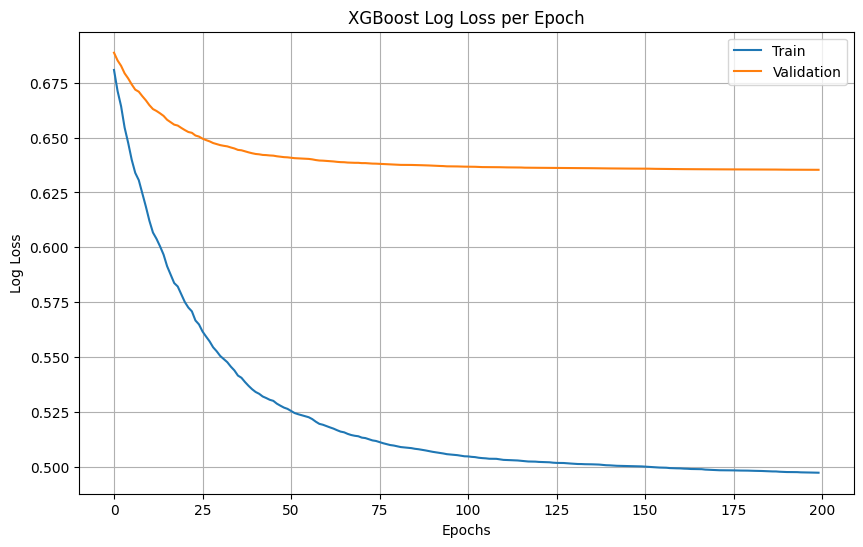

<Figure size 1000x800 with 0 Axes>

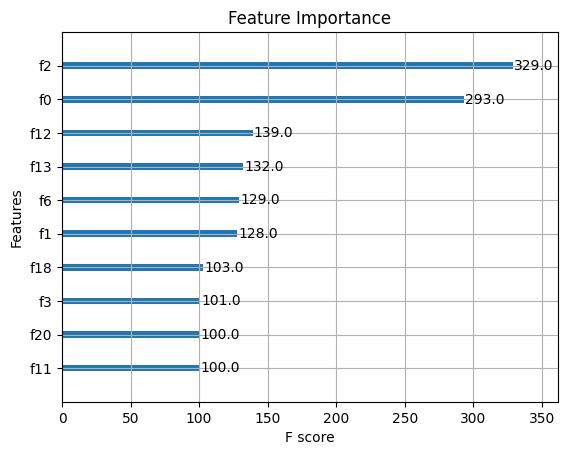

In [3]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Initialize XGBoost Classifier
xgb_model = XGBClassifier(
    n_estimators=200,        # Number of boosting rounds
    max_depth=4,             # Maximum depth of each tree
    learning_rate=0.1,       # Step size shrinkage
    colsample_bytree=0.8,    # Subsample ratio of columns
    subsample=0.8,           # Subsample ratio of the training set
    random_state=42,         # Seed for reproducibility
    use_label_encoder=False, # Disable deprecated warning
    eval_metric="logloss"    # Evaluation metric
)

# Track training and validation accuracy
eval_set = [(X_train_balanced_scaled, y_train_balanced), (X_val_scaled, y_val)]
xgb_model.fit(
    X_train_balanced_scaled, y_train_balanced,
    eval_set=eval_set, verbose=False
)

# Predict on validation data
y_val_pred_xgb = xgb_model.predict(X_val_scaled)

# Evaluate the model
xgb_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_xgb),
    "Precision": precision_score(y_val, y_val_pred_xgb),
    "Recall": recall_score(y_val, y_val_pred_xgb),
    "F1 Score": f1_score(y_val, y_val_pred_xgb)
}
print("XGBoost Metrics:", xgb_metrics)
print("Confusion Matrix:\n", confusion_matrix(y_val, y_val_pred_xgb))
print("Classification Report:\n", classification_report(y_val, y_val_pred_xgb))

# Plot Accuracy vs Epochs
results = xgb_model.evals_result()
epochs = len(results['validation_0']['logloss'])
x_axis = range(0, epochs)

plt.figure(figsize=(10, 6))
plt.plot(x_axis, results['validation_0']['logloss'], label='Train')
plt.plot(x_axis, results['validation_1']['logloss'], label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Log Loss')
plt.title('XGBoost Log Loss per Epoch')
plt.legend()
plt.grid()
plt.show()

# Feature Importance Plot
plt.figure(figsize=(10, 8))
plot_importance(xgb_model, max_num_features=10, importance_type='weight', title="Feature Importance")
plt.show()


Linear Discriminant Analysis (LDA) Metrics: {'Accuracy': 0.5995327479255619, 'Precision': 0.32905718701700154, 'Recall': 0.2084087905633596, 'F1 Score': 0.25519163345419676}
Confusion Matrix (LDA):
 [[32952  8682]
 [16173  4258]]
Classification Report (LDA):
               precision    recall  f1-score   support

       False       0.67      0.79      0.73     41634
        True       0.33      0.21      0.26     20431

    accuracy                           0.60     62065
   macro avg       0.50      0.50      0.49     62065
weighted avg       0.56      0.60      0.57     62065

Quadratic Discriminant Analysis (QDA) Metrics: {'Accuracy': 0.617562233142673, 'Precision': 0.3588692458792382, 'Recall': 0.20566785766727033, 'F1 Score': 0.2614810205351587}
Confusion Matrix (QDA):
 [[34127  7507]
 [16229  4202]]
Classification Report (QDA):
               precision    recall  f1-score   support

       False       0.68      0.82      0.74     41634
        True       0.36      0.21      0.26

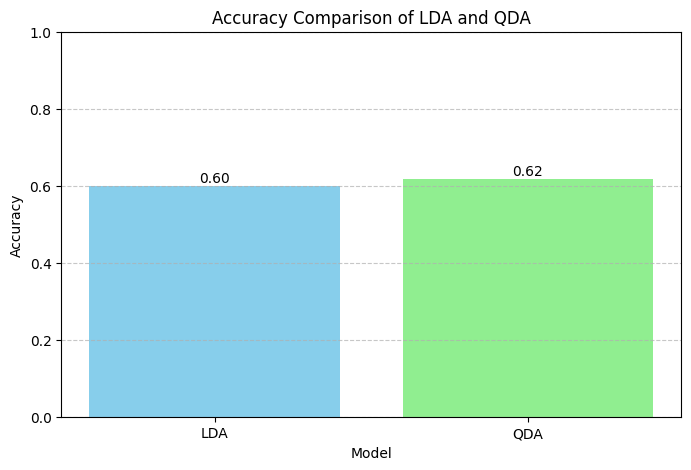

In [5]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Initialize LDA
lda = LinearDiscriminantAnalysis()
lda.fit(X_train_balanced_scaled, y_train_balanced)  # Train LDA on balanced training data

# Predict with LDA
y_val_pred_lda = lda.predict(X_val_scaled)

# Evaluate LDA
lda_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_lda),
    "Precision": precision_score(y_val, y_val_pred_lda),
    "Recall": recall_score(y_val, y_val_pred_lda),
    "F1 Score": f1_score(y_val, y_val_pred_lda)
}
print("Linear Discriminant Analysis (LDA) Metrics:", lda_metrics)
print("Confusion Matrix (LDA):\n", confusion_matrix(y_val, y_val_pred_lda))
print("Classification Report (LDA):\n", classification_report(y_val, y_val_pred_lda))

# Initialize QDA
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_balanced_scaled, y_train_balanced)  # Train QDA on balanced training data

# Predict with QDA
y_val_pred_qda = qda.predict(X_val_scaled)

# Evaluate QDA
qda_metrics = {
    "Accuracy": accuracy_score(y_val, y_val_pred_qda),
    "Precision": precision_score(y_val, y_val_pred_qda),
    "Recall": recall_score(y_val, y_val_pred_qda),
    "F1 Score": f1_score(y_val, y_val_pred_qda)
}
print("Quadratic Discriminant Analysis (QDA) Metrics:", qda_metrics)
print("Confusion Matrix (QDA):\n", confusion_matrix(y_val, y_val_pred_qda))
print("Classification Report (QDA):\n", classification_report(y_val, y_val_pred_qda))

# Plot Training and Validation Accuracy Curves
models = ['LDA', 'QDA']
accuracies = [lda_metrics['Accuracy'], qda_metrics['Accuracy']]

plt.figure(figsize=(8, 5))
plt.bar(models, accuracies, color=['skyblue', 'lightgreen'])
plt.title("Accuracy Comparison of LDA and QDA")
plt.ylabel("Accuracy")
plt.xlabel("Model")
plt.ylim(0, 1)
for i, acc in enumerate(accuracies):
    plt.text(i, acc + 0.01, f"{acc:.2f}", ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


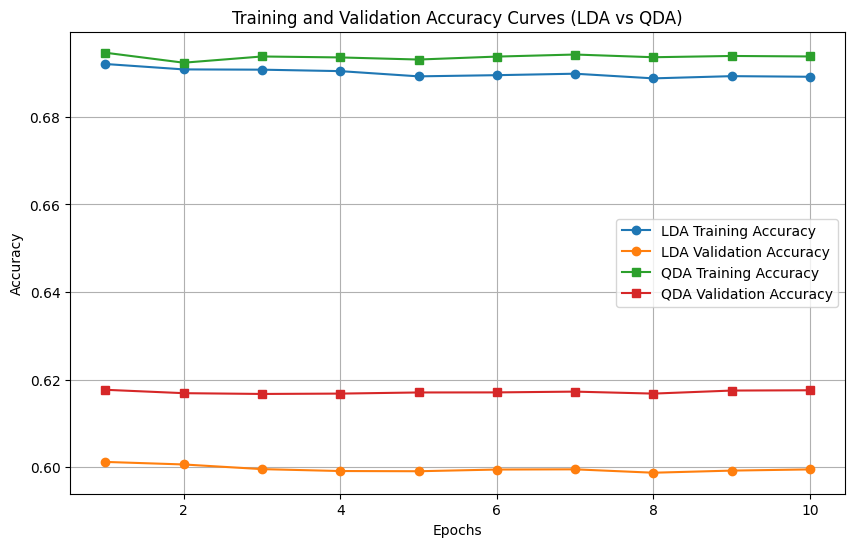

In [6]:
import numpy as np
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

# Split training data into smaller chunks (simulating epochs)
def simulate_epochs(model, X_train, y_train, X_val, y_val, n_epochs=10):
    train_accuracies = []
    val_accuracies = []
    chunk_size = len(X_train) // n_epochs  # Determine size of each chunk

    for i in range(1, n_epochs + 1):
        # Use the first i chunks for training
        X_train_epoch = X_train[:i * chunk_size]
        y_train_epoch = y_train[:i * chunk_size]

        # Fit the model on the current subset
        model.fit(X_train_epoch, y_train_epoch)

        # Calculate training accuracy
        y_train_pred = model.predict(X_train_epoch)
        train_acc = accuracy_score(y_train_epoch, y_train_pred)
        train_accuracies.append(train_acc)

        # Calculate validation accuracy
        y_val_pred = model.predict(X_val)
        val_acc = accuracy_score(y_val, y_val_pred)
        val_accuracies.append(val_acc)

    return train_accuracies, val_accuracies

# Shuffle training data for better epoch simulation
X_train_shuffled, y_train_shuffled = shuffle(X_train_balanced_scaled, y_train_balanced, random_state=42)

# Initialize LDA and QDA
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

# Simulate epochs for LDA
lda_train_acc, lda_val_acc = simulate_epochs(lda, X_train_shuffled, y_train_shuffled, X_val_scaled, y_val, n_epochs=10)

# Simulate epochs for QDA
qda_train_acc, qda_val_acc = simulate_epochs(qda, X_train_shuffled, y_train_shuffled, X_val_scaled, y_val, n_epochs=10)

# Plot Training and Validation Accuracy Curves
epochs = range(1, 11)

plt.figure(figsize=(10, 6))

# LDA Curves
plt.plot(epochs, lda_train_acc, label="LDA Training Accuracy", marker='o')
plt.plot(epochs, lda_val_acc, label="LDA Validation Accuracy", marker='o')

# QDA Curves
plt.plot(epochs, qda_train_acc, label="QDA Training Accuracy", marker='s')
plt.plot(epochs, qda_val_acc, label="QDA Validation Accuracy", marker='s')

plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy Curves (LDA vs QDA)")
plt.legend()
plt.grid()
plt.show()
